In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from sklearn.preprocessing import OneHotEncoder
from quantbullet.linear_product_model import LinearProductModelToolkit

In [2]:
np.random.seed(42)
n_samples = int( 10e4 )
df = pd.DataFrame({
    'x1': 10 + 3 * np.random.randn(n_samples),
    'x2': 20 + 3 * np.random.randn(n_samples),
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = np.cos(df['x1']) + np.sin(df['x2']) + \
    np.random.randn(n_samples) * 0.5 + \
    np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10

In [3]:
feature_config = {
    'x1': FlatRampTransformer( knots=list( np.arange(4, 16, 1 ) ), include_bias=True ),
    'x2': FlatRampTransformer( knots=list( np.arange(14, 26, 1 ) ), include_bias=True ),
    'x3': OneHotEncoder( drop=None )
}

In [4]:
tk = LinearProductModelToolkit( feature_config ).fit( df )
feature_groups = tk.feature_groups_

In [5]:
train_df = tk.get_train_df( df )

## Regression

In [6]:
from quantbullet.linear_product_model import LinearProductRegressorBCD

lprm_ols = LinearProductRegressorBCD()

In [7]:
lprm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, Loss: 5.2810e-01
Iteration 2/10, Loss: 5.2635e-01
Iteration 3/10, Loss: 5.2635e-01
Converged at iteration 3 with Loss: 5.2635e-01


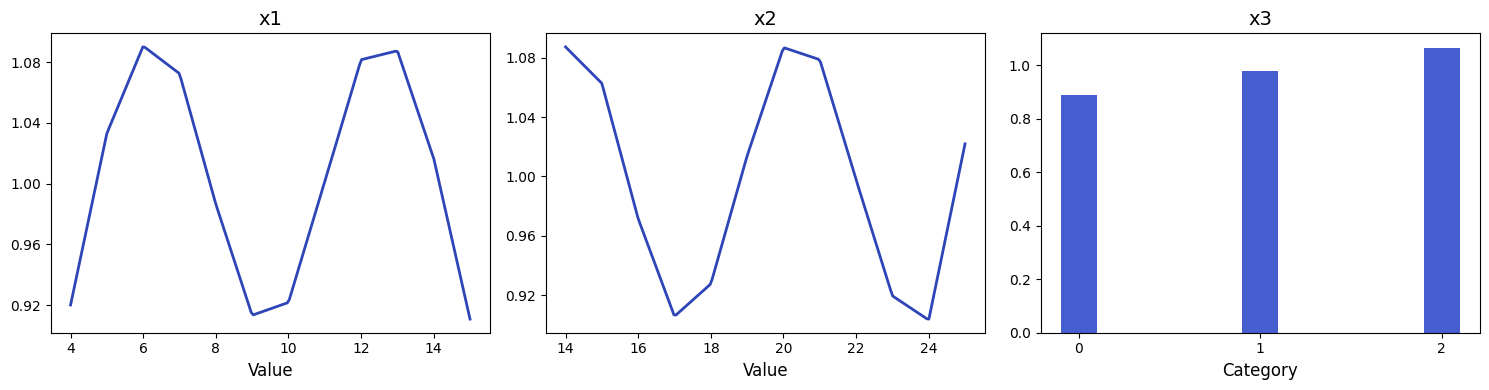

In [8]:
tk.plot_model_curves( lprm_ols )

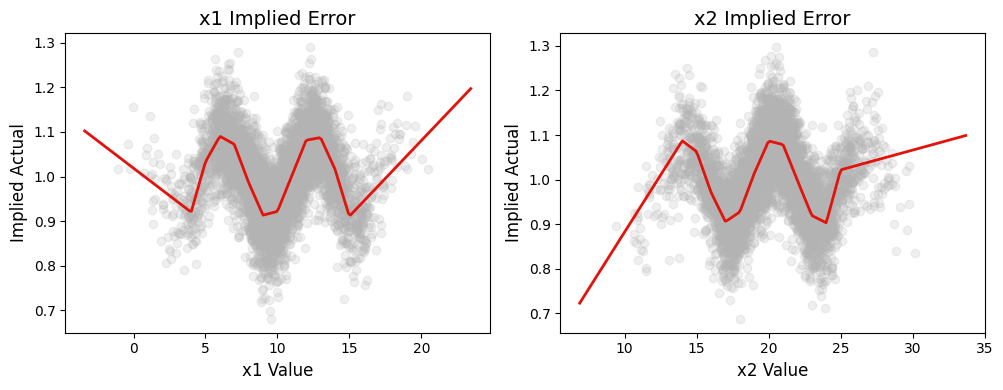

In [9]:
tk.plot_model_implied_errors( lprm_ols, df, df['y'], train_df, sample_frac=0.05 )

## Classification

In [10]:
np.random.seed(15)
probs = 1 / (1 + np.exp(-(df['y'] - 15)))
df['binary_y'] = np.random.binomial(1, probs)
df['binary_y'].mean()

np.float64(0.05182)

In [11]:
df['x1'] = np.clip(df['x1'], 0, 20)
df['x2'] = np.clip(df['x2'], 10, 30)

In [12]:
from quantbullet.linear_product_model import LinearProductRegressorBCD

lprm_bcd = LinearProductRegressorBCD()

lprm_bcd.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, Loss: 4.5910e-02
Iteration 2/10, Loss: 4.5908e-02
Iteration 3/10, Loss: 4.5908e-02
Converged at iteration 3 with Loss: 4.5908e-02


In [13]:
tk = LinearProductModelToolkit( feature_config ).fit( df )

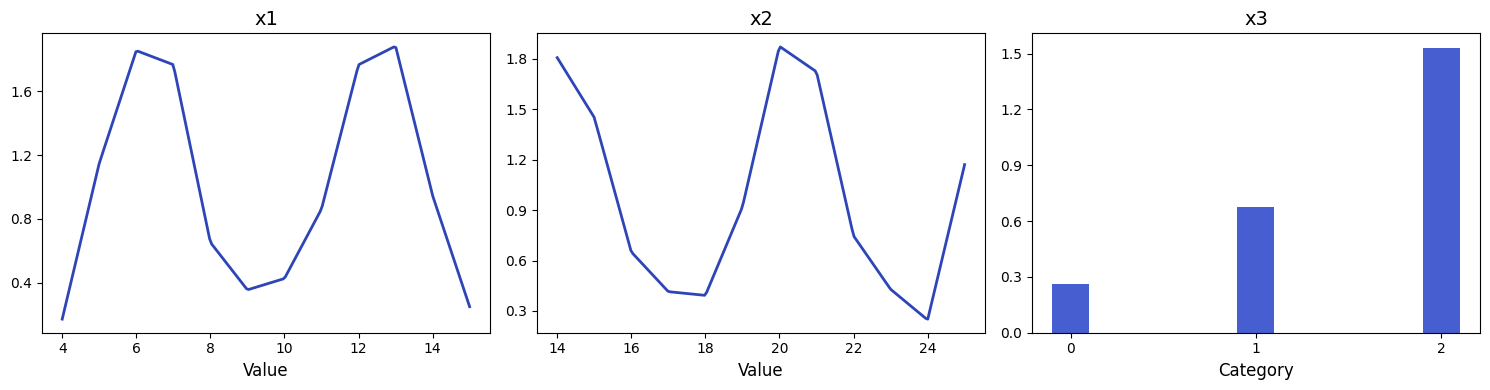

In [14]:
tk.plot_model_curves( lprm_bcd )

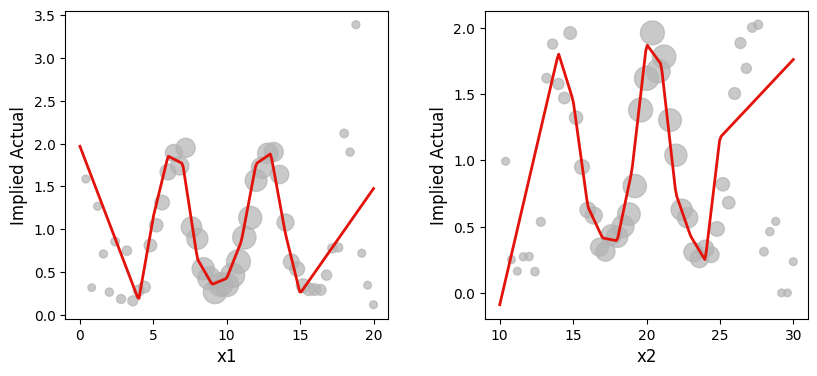

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: xlabel='x1', ylabel='Implied Actual'>,
        <Axes: xlabel='x2', ylabel='Implied Actual'>, <Axes: >],
       dtype=object))

In [15]:
tk.plot_discretized_implied_errors( lprm_bcd, df, df['binary_y'], train_df, sample_frac=1, n_bins=50 )

In [16]:
from quantbullet.utils.debug import object_to_pickle

In [17]:
object_to_pickle( lprm_bcd, 'lprm_bcd.pkl' )